In [92]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd


Start building a simple tool that checks all shapes in the database. The tool should output, for each shape

-   the class of the shape
-   the number of faces and vertices of the shape
-   the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
-   the axis-aligned 3D bounding box of the shapes

In [93]:
def viz_mesh(obj_file_path, vis_option = "wireframe_on_shaded"):   

        mesh = o3d.io.read_triangle_mesh(obj_file_path)
        mesh.compute_vertex_normals() 
        if vis_option == "smoothshade":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720)
        elif vis_option == "wireframe_on_shaded":
            o3d.visualization.draw_geometries([mesh], width=1280, height=720, mesh_show_wireframe=True)
        elif vis_option == "wireframe":
            # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
            wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh) 
            o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
        elif vis_option == "world_axes":
            # Display the mesh including a world axis system.

            # Create the endpoints of each line. Each line is unit-length.
            # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
            line_endpoints = [
                [0, 0, 0],
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]

            # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
            line_indices = [[0, 1], [0, 2], [0, 3]]

            # Create a line set from the endpoints and indices
            world_axes = o3d.geometry.LineSet(
                points=o3d.utility.Vector3dVector(line_endpoints),
                lines=o3d.utility.Vector2iVector(line_indices),
            )

            # Render the line set and the mesh
            o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)
        elif vis_option == "black_background":
            # Create visualizer
            vis = o3d.visualization.Visualizer()
            vis.create_window()
            vis.add_geometry(mesh)

            # Set render options (e.g. background color)
            opt = vis.get_render_option()
            opt.background_color = np.asarray([0, 0, 0])

            # Run the visualizer
            vis.run()
            vis.destroy_window()


In [94]:
dbpath = r"./database/"
mesh_path = dbpath + r"Sign/m1675.obj"

mesh_data = []

for class_folder in os.listdir(dbpath):
    # Construct the full path to the subfolder
    class_folder_path = os.path.join(dbpath, class_folder)
    
    # Check if the item in the directory is a directory (to skip files)
    if os.path.isdir(class_folder_path):
        # Assuming the class folder name is the class name
        class_name = class_folder
        
        # Iterate through .obj files in the subfolder
        for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
            # Read the .obj file using tripy
            mesh = o3d.io.read_triangle_mesh(obj_file_path)
            filename = obj_file_path.split("\\")[-1]
            vertices = np.asarray(mesh.vertices)
            triangles = np.asarray(mesh.triangles)
            filepath = class_folder_path
            mesh_data.append([class_name, filename, len(vertices), len(triangles), obj_file_path])

            # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")

In [95]:
obj_file_path

'./database/WheelChair\\D00846.obj'

In [96]:
df = pd.DataFrame(mesh_data, columns=["Class", "Filename", "Vertices", "Triangles", "Filepath"])
print(df)

                Class    Filename  Vertices  Triangles  \
0     AircraftBuoyant   m1337.obj       201        340   
1     AircraftBuoyant   m1338.obj      8761      16960   
2     AircraftBuoyant   m1339.obj      1878       6173   
3     AircraftBuoyant   m1340.obj       778       1457   
4     AircraftBuoyant   m1341.obj       425        824   
...               ...         ...       ...        ...   
2478       WheelChair  D00687.obj      8188      16268   
2479       WheelChair  D00720.obj     43912      83378   
2480       WheelChair  D00782.obj      1134       1940   
2481       WheelChair  D00821.obj      8188      16268   
2482       WheelChair  D00846.obj      8834      17196   

                                  Filepath  
0     ./database/AircraftBuoyant\m1337.obj  
1     ./database/AircraftBuoyant\m1338.obj  
2     ./database/AircraftBuoyant\m1339.obj  
3     ./database/AircraftBuoyant\m1340.obj  
4     ./database/AircraftBuoyant\m1341.obj  
...                              

In [97]:
import pickle
df.to_pickle("dataframe.pkl")

In [98]:
df = pd.read_pickle("dataframe.pkl")


Min, Max and average Number of triangles and Vertices over the entire dataset

In [99]:
df["Vertices"].min(), df["Vertices"].max(), df["Vertices"].mean()

(16, 73440, 5025.5453080950465)

In [100]:
df["Triangles"].min(), df["Triangles"].max(), df["Triangles"].mean()

(16, 129881, 10691.52597664116)

### The type of faces (e.g. only triangles, only quads, mixes of triangles and quads)

In [101]:
# dbpath = r"./database/"
# mesh_path = dbpath + r"Sign/m1675.obj"

# mesh_data = []

# for class_folder in os.listdir(dbpath):
#     # Construct the full path to the subfolder
#     class_folder_path = os.path.join(dbpath, class_folder)
    
#     # Check if the item in the directory is a directory (to skip files)
#     if os.path.isdir(class_folder_path):
#         # Assuming the class folder name is the class name
#         class_name = class_folder
        
#         # Iterate through .obj files in the subfolder
#         for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
#             # Read the .obj file using tripy
#             # mesh = o3d.io.read_triangle_mesh(obj_file_path)
#             with open(obj_file_path, 'r') as file:
#             # Iterate through each line in the file
#                 for line in file:
#                     # Check if the line starts with 'f' (case-sensitive)
#                     if line.startswith('f'):
#                         if len(line.split(" "))!= 4:
#                             print(len(line.split(" ")))

#             # print(f"Class: {class_name}, Vertices: {len(vertices)}, Triangles: {len(triangles)}")

Only shapes of 3, otherwise it would have printed out something

### Axis-aligned bouding box

In [102]:
mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
aabb = mesh.get_axis_aligned_bounding_box()


# Get the minimum and maximum coordinates of the AABB
min_coords = aabb.get_min_bound()
max_coords = aabb.get_max_bound()

# Define the eight corners of the AABB
vertices = [
    min_coords,
    [max_coords[0], min_coords[1], min_coords[2]],
    [max_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], max_coords[1], min_coords[2]],
    [min_coords[0], min_coords[1], max_coords[2]],
    [max_coords[0], min_coords[1], max_coords[2]],
    max_coords,
    [min_coords[0], max_coords[1], max_coords[2]]
]

# Define the edges of the AABB
lines = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7]
]

# Create a LineSet to visualize the AABB
aabb_line_set = o3d.geometry.LineSet()
aabb_line_set.points = o3d.utility.Vector3dVector(vertices)
aabb_line_set.lines = o3d.utility.Vector2iVector(lines)

# Customize the bounding box appearance
line_set_color = np.array([1.0, 0.0, 0.0])  # Red color (R, G, B)
line_set_line_width = 5.0  # Adjust line width as needed

# Set the line set's color and line width
aabb_line_set.paint_uniform_color(line_set_color)
# aabb_line_set.line_width = line_set_line_width

# Visualize the object and its AABB
o3d.visualization.draw_geometries([mesh, aabb_line_set])

### Histogram

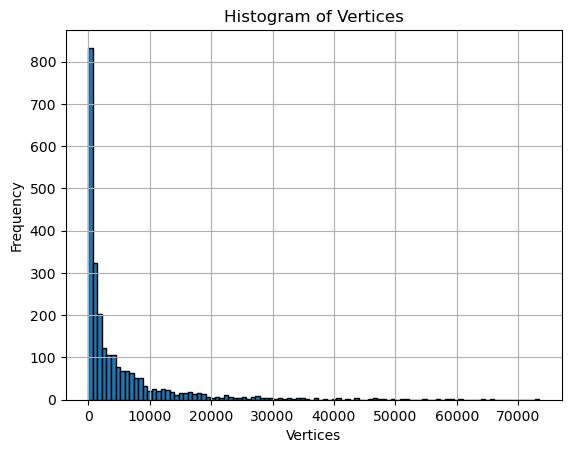

In [103]:
import matplotlib.pyplot  as plt
# Create a histogram
plt.hist(df['Vertices'], bins=100, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel('Vertices')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices')
plt.grid(True)

# Display the histogram
plt.show()

### Outliers

In [104]:
highVertexDf = df[df['Vertices'] > 60000]
highVertexDf

,Class,Filename,Vertices,Triangles,Filepath
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
1705,PlantIndoors,D00080.obj,64126,34887,./database/PlantIndoors\D00080.obj
2095,Skyscraper,D00058.obj,73440,53448,./database/Skyscraper\D00058.obj


In [105]:
highTrianglesDf = df[df['Triangles'] > 100000]
highTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
100,Bicycle,D00462.obj,56754,111471,./database/Bicycle\D00462.obj
143,Biplane,m1120.obj,65722,129881,./database/Biplane\m1120.obj
366,Car,m1510.obj,54710,109357,./database/Car\m1510.obj
396,Car,m1544.obj,60326,116378,./database/Car\m1544.obj
406,Car,m1556.obj,35131,119540,./database/Car\m1556.obj
457,Chess,m1595.obj,60667,121343,./database/Chess\m1595.obj
944,Helicopter,m1308.obj,58392,116773,./database/Helicopter\m1308.obj


In [106]:
lowVertexDf = df[df['Vertices'] < 25]
lowVertexDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
716,Drum,D00709.obj,24,132,./database/Drum\D00709.obj
996,House,m434.obj,22,26,./database/House\m434.obj
1587,MultiSeat,m784.obj,24,36,./database/MultiSeat\m784.obj
2261,Tool,m1102.obj,24,52,./database/Tool\m1102.obj


In [150]:
lowTrianglesDf = df[df['Triangles'] < 25]
lowTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,16,16,./database/Door\D01121.obj
676,Door,D01194.obj,18,18,./database/Door\D01194.obj
678,Door,m1708.obj,16,16,./database/Door\m1708.obj
1015,House,m462.obj,25,22,./database/House\m462.obj


In [108]:
highVertexDf.iloc[4,[0,1,2]]

Class       Skyscraper
Filename    D00058.obj
Vertices         73440
Name: 2095, dtype: object

In [126]:
viz_mesh(highVertexDf.iloc[4]["Filepath"])

In [132]:
viz_mesh(lowVertexDf.iloc[5]["Filepath"])

In [196]:
viz_mesh("./database/House\D00001.obj")

In [195]:
viz_mesh("./database/House\m423.obj")

In [134]:
df[df['Class']=="House"]

,Class,Filename,Vertices,Triangles,Filepath
970,House,D00001.obj,46252,90161,./database/House\D00001.obj
971,House,D00044.obj,10194,19412,./database/House\D00044.obj
972,House,D00091.obj,495,768,./database/House\D00091.obj
973,House,D00095.obj,1681,3304,./database/House\D00095.obj
974,House,D00286.obj,28394,62973,./database/House\D00286.obj
975,House,D00325.obj,8465,16975,./database/House\D00325.obj
976,House,D00359.obj,34797,66144,./database/House\D00359.obj
977,House,D00389.obj,27486,50407,./database/House\D00389.obj
978,House,D00415.obj,25131,46904,./database/House\D00415.obj
979,House,D00454.obj,5500,10208,./database/House\D00454.obj


### Resampling outliers

Next, if outliers contain poorly-sampled shapes (having under 100 vertices and/or faces), you need to refine these, so that feature extraction (next step) will work well. Refinement means splitting large faces into smaller ones. There are several ways to refine a mesh:

In [73]:
import pymeshlab as pml

In [192]:
# Parameters
path = lowTrianglesDf.iloc[3]["Filepath"]

def resample_mesh(path, filename, target_edge_length = 0.02, iterations = 7):
         
    mesh_lowpoly = pml.MeshSet()
    mesh_lowpoly.load_new_mesh(path)

    # Create refined (i.e. high-poly) versions of it
    print(f"Vertices before: {mesh_lowpoly.current_mesh().vertex_number()}, Faces before: {mesh_lowpoly.current_mesh().face_number()}")
    print(f"Refining mesh ({iterations} iterations)... ")
    mesh_lowpoly.meshing_isotropic_explicit_remeshing(
        targetlen=pml.AbsoluteValue(target_edge_length), iterations=iterations)
    newFilePath = f"./resampled/{filename}"
    mesh_lowpoly.save_current_mesh(newFilePath)
    print("Finished.")
    vAfter = mesh_lowpoly.current_mesh().vertex_number()
    fAfter = mesh_lowpoly.current_mesh().face_number()
    print(f"Vertices after: {vAfter}, Faces after: {fAfter}")
    return vAfter, fAfter, newFilePath



In [200]:
for i, row in df.iterrows():
    if row['Vertices'] < 100 or row['Triangles'] < 100:
        vAfter, fAfter, newFilePath = resample_mesh(row["Filepath"], row["Filename"] )
        df.at[i, "Vertices"] = vAfter
        df.at[i, "Triangles"] = fAfter
        df.at[i, "Filepath"] = newFilePath

Vertices before: 44, Faces before: 1680
Refining mesh (7 iterations)... 
Finished.
Vertices after: 927, Faces after: 1849
Vertices before: 41, Faces before: 54
Refining mesh (7 iterations)... 
Finished.
Vertices after: 808, Faces after: 1454
Vertices before: 93, Faces before: 182
Refining mesh (7 iterations)... 
Finished.
Vertices after: 2358, Faces after: 4712
Vertices before: 40, Faces before: 45
Refining mesh (7 iterations)... 
Finished.
Vertices after: 4575, Faces after: 8534
Vertices before: 33, Faces before: 80
Refining mesh (7 iterations)... 
Finished.
Vertices after: 5873, Faces after: 11850
Vertices before: 89, Faces before: 168
Refining mesh (7 iterations)... 
Finished.
Vertices after: 4205, Faces after: 8312
Vertices before: 89, Faces before: 168
Refining mesh (7 iterations)... 
Finished.
Vertices after: 4199, Faces after: 8300
Vertices before: 29, Faces before: 43
Refining mesh (7 iterations)... 
Finished.
Vertices after: 7348, Faces after: 14465
Vertices before: 46, Faces 

In [202]:
df[df['Vertices']<111]

,Class,Filename,Vertices,Triangles,Filepath
204,Bird,m47.obj,101,165,./database/Bird\m47.obj
222,Bookset,D01122.obj,108,624,./database/Bookset\D01122.obj
1662,NonWheelChair,m807.obj,104,184,./database/NonWheelChair\m807.obj
1910,RectangleTable,m913.obj,104,188,./database/RectangleTable\m913.obj
2000,Shelf,m852.obj,104,228,./database/Shelf\m852.obj
2001,Shelf,m853.obj,100,228,./database/Shelf\m853.obj
2120,Spoon,D00422.obj,109,528,./database/Spoon\D00422.obj
2121,Spoon,D00474.obj,43,70,./resampled/D00474.obj


Vertices before: 72, Faces before: 363
Refining mesh (7 iterations)... 
Finished.
Vertices after: 43, Faces after: 70

In [203]:
viz_mesh('./resampled/D00474.obj')

In [205]:
viz_mesh('./database/Spoon/D00474.obj')

In [194]:
lowTrianglesDf

,Class,Filename,Vertices,Triangles,Filepath
665,Door,D01121.obj,6410,12490,./resampled/D01121.obj
676,Door,D01194.obj,2240,4219,./resampled/D01194.obj
678,Door,m1708.obj,6407,12484,./resampled/m1708.obj
1015,House,m462.obj,6150,11748,./resampled/m462.obj


In [117]:
mesh_lowpoly.current_mesh().vertex_number(), mesh_lowpoly.current_mesh().face_number()

(2740, 5124)

In [199]:
viz_mesh(path)

In [198]:
viz_mesh("refined_iter4.obj")